# Basic Notions of Portfolio Analysis

### Installing Pyfolio and PyPortfolioOpt

In [1]:
! pip install pyfolio
! pip install PyPortfolioOpt

     |████████████████████████████████| 91 kB 1.9 MB/s 
     |████████████████████████████████| 50 kB 3.8 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88667 sha256=9a55be0c063ce76a20e78c7baf93bb40bfaeab3d84ca6cd149ec8cdda37ddb86
  Stored in directory: /root/.cache/pip/wheels/2a/72/98/e93e1a091c5c2255ee49b299d4b8e955bab09fd3b9695f2218
  Created wheel for empyrical: filename=empyrical-0.5.3-py3-none-any.whl size=37090 sha256=585034bb6ef11e623e4fdd04aaf423ea1d7cf7d5210448d366c3e5a8595d5f11
  Stored in directory: /root/.cache/pip/wheels/9e/5a/69/db414a9fb2abedee8b26f6efd5d0715e68ab0101caaa5f1a9c
Successfully built pyfolio empyrical
     |████████████████████████████████| 49 kB 1.3 MB/s 
     |████████████████████████████████| 947 kB 6.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.0.31-cp36-cp36m-linux_x86_64.whl size=2192630 

### All Imports

In [2]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


### Useful Functions

In [3]:
def join_df_list(df_list, tolerance):
    """
    Performs the merge_asof in a list of dfs
    using 'tolerance' as tolerance.

    :param df_list: list of data frames
    :type df_list: [pd.DataFrame]
    :param tolerance: difference of days between
                      data frames that can be
                      tolerated
    :type tolerance: pd.Timestamp
    :return: merged dataframe
    :rtype: pd.DataFrame
    """
    size = len(df_list)
    df = pd.merge_asof(df_list[0], df_list[1],
                       left_index=True,
                       right_index=True,
                       tolerance=tolerance)
    for i in range(2, size):
        df = pd.merge_asof(df, df_list[i],
                           left_index=True,
                           right_index=True,
                           tolerance=tolerance)
    return df


def show_clean_p(p):
    p_show = p.transpose()[p.transpose() > 0.001].dropna()
    p_show = p_show.transpose()
    p_show = (p_show.transpose()[0]).map(lambda x: "{:.1%}".format(x)).to_frame().transpose()
    display(HTML(p_show.to_html()))

## All Ibovespa Tickers

In [4]:
ibov = ["ABEV3", "AZUL4", "B3SA3", "BBAS3", "BBDC3", "BBDC4", "BBSE3", "BPAC11", "BRAP4",
        "BRDT3", "BRFS3", "BRKM5", "BRML3", "BTOW3", "CCRO3", "CIEL3", "CMIG4", "COGN3", "CRFB3",
        "CSAN3", "CSNA3", "CVCB3", "CYRE3", "ECOR3", "EGIE3", "ELET3", "ELET6", "EMBR3", "ENBR3",
        "EQTL3", "FLRY3", "GGBR4", "GNDI3", "GOAU4", "GOLL4", "HAPV3", "HGTX3", "HYPE3", "IGTA3",
        "IRBR3", "ITSA4", "ITUB4", "JBSS3", "KLBN11", "LAME4", "LREN3", "MGLU3", "MRFG3", "MRVE3", "MULT3",
        "NTCO3", "PCAR4", "PETR3", "PETR4", "QUAL3", "RADL3", "RAIL3", "RENT3", "SANB11", "SBSP3", "SMLS3",
        "SULA11", "SUZB3", "TAEE11", "TIMP3", "TOTS3", "UGPA3", "USIM5", "VALE3", "VIVT4", "VVAR3", "WEGE3", "YDUQ3"]


## Loading Market Data

In [5]:
df = pd.read_csv(path)
df.loc[:, "datetime"] = df.datetime.map(pd.Timestamp)

## Selecting the tickers using a start date

In [6]:
df_sort = df.set_index(["ticker", "datetime"]).sort_index()
start_date = "2016-02-02"


ibov_mini = []
for ticker in ibov:
    ts = df_sort.xs(ticker)
    if ts.index.min() <= pd.Timestamp(start_date):
        ibov_mini.append(ticker)

del df_sort

ratio = len(ibov_mini)/len(ibov)
print("percentage of ibov's tickers that will be used in the analysis = {:.1%}".format(ratio))

percentage of ibov's tickers that will be used in the analysis = 80.8%


## Splitting the dataset

In [7]:
df_sort = df.set_index(["datetime"]).sort_index()
df_sort = df_sort[df_sort.index >= start_date]
df_sort = df_sort[df_sort.ticker.isin(ibov_mini)]
df_train = df_sort[df_sort.index < "2019-01-01"]
df_test = df_sort[df_sort.index >= "2019-01-01"]

del df_sort

df_train = df_train.reset_index().set_index(["ticker", "datetime"]).sort_index()
df_test = df_test.reset_index().set_index(["ticker", "datetime"]).sort_index()



## Getting all close prices 

In [8]:
all_prices = []

for ticker in ibov_mini:
    series = df_train.xs(ticker).close
    series.name = ticker
    all_prices.append(series.to_frame())
    
all_prices = join_df_list(all_prices, tolerance=pd.Timedelta("10days"))

# dealing with missing data
all_prices = all_prices.dropna(1)




## First example, two naive types of portfolios:
 - **Portfolio 1**: Uniform weights
 - **Portfolio 2**: Concentrated on Banks 

In [9]:
ibov_mini = list(all_prices.columns)

n_ibov = len(ibov_mini)


uniform_weigths = np.ones((n_ibov)) / n_ibov
banks_weigths = np.ones((n_ibov))/ n_ibov
p1 = pd.DataFrame([uniform_weigths], columns=ibov_mini)
p2 = pd.DataFrame([banks_weigths], columns=ibov_mini)

p2.loc[:, "ITSA4"] = 0.2
p2.loc[:, "ITUB4"] = 0.2
p2.loc[:, "BBDC3"] = 0.2
p2.loc[:, "BBDC4"] = 0.2

p2 = p2 / p2.sum(1)[0]

uniform_weigths = p1.values.flatten()
banks_weigths = p2.values.flatten()




print("\nportfolio 1:\n")
p1_show = (p1.transpose()[0]).map(lambda x: "{:.1%}".format(x)).to_frame().transpose()
display(HTML(p1_show.to_html()))

print("\nportfolio 2:\n")
p2_show = (p2.transpose()[0]).map(lambda x: "{:.1%}".format(x)).to_frame().transpose()
display(HTML(p2_show.to_html()))


portfolio 1:



,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,ELET3,ELET6,EMBR3,ENBR3,EQTL3,FLRY3,GGBR4,GOAU4,GOLL4,HGTX3,HYPE3,IGTA3,ITSA4,ITUB4,KLBN11,LAME4,LREN3,MGLU3,MRFG3,MRVE3,MULT3,PCAR4,PETR3,PETR4,QUAL3,RADL3,RENT3,SANB11,SBSP3,SULA11,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
0,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%,1.8%



portfolio 2:



,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRML3,BTOW3,CCRO3,CIEL3,CMIG4,CSAN3,CSNA3,CVCB3,CYRE3,ECOR3,ELET3,ELET6,EMBR3,ENBR3,EQTL3,FLRY3,GGBR4,GOAU4,GOLL4,HGTX3,HYPE3,IGTA3,ITSA4,ITUB4,KLBN11,LAME4,LREN3,MGLU3,MRFG3,MRVE3,MULT3,PCAR4,PETR3,PETR4,QUAL3,RADL3,RENT3,SANB11,SBSP3,SULA11,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
0,1.0%,1.0%,11.6%,11.6%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,11.6%,11.6%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%,1.0%


### Plotting Prices Drawdown

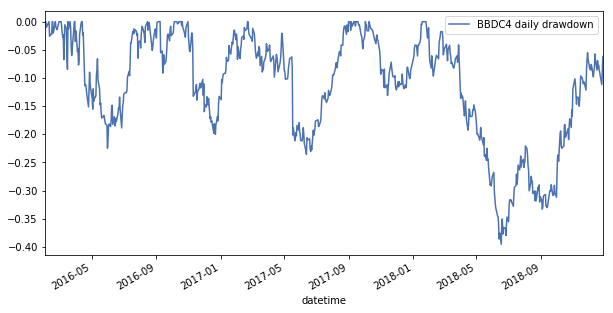

In [10]:
ticker = "BBDC4"
prices = all_prices[ticker]
window = 250

def get_daily_max_drawdown(prices, window):
    max_rolling = prices.rolling(min_periods=1, window=window).max()
    daily_drawdown = (prices / max_rolling) - 1
    max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
    return daily_drawdown,max_daily_drawdown

max_rolling = prices.rolling(min_periods=1, window=window).max()

daily_drawdown, max_daily_drawdown = get_daily_max_drawdown(prices, window)
daily_drawdown.name = "{} daily drawdown".format(ticker)  

fig, ax = plt.subplots(figsize=(10,5))
daily_drawdown.plot();
plt.legend(loc="best");
plt.show()

### Using the average daily return to calculate portfolio return

In [11]:
returns = all_prices.pct_change()
mean_daily_returns = returns.mean().values

p1_return = np.dot(mean_daily_returns, uniform_weigths)
p2_return = np.dot(mean_daily_returns, banks_weigths)

print("portfolio 1 average daily return = {:.4%}".format(p1_return))
print("portfolio 2 average daily return = {:.4%}".format(p2_return))

portfolio 1 average daily return = 0.1338%
portfolio 2 average daily return = 0.1229%


### Annualized return, variance and standart deviation

In [12]:
def get_annualized_return(prices, weigths):
    months = (prices.index[-1] - prices.index[0]) / np.timedelta64(1, 'M')
    months = np.floor(months)
    total_return = (prices.iloc[-1].dot(weigths) - prices.iloc[0].dot(weigths)) / prices.iloc[0].dot(weigths)
    annualized_return = ((1 + total_return) ** (12 / months)) - 1
    return annualized_return


p1_annual_return = get_annualized_return(all_prices, uniform_weigths)
p2_annual_return = get_annualized_return(all_prices, banks_weigths)

def get_portfolio_variance(returns, weigths):
    covariance_returns = returns.cov() * 250
    return np.dot(weigths.T, np.dot(covariance_returns, weigths))

uni_var = get_portfolio_variance(returns, uniform_weigths)
banks_var = get_portfolio_variance(returns, banks_weigths)

print("portfolio 1 annualized return = {:.4%}".format(p1_annual_return))
print("portfolio 1 annualized variance = {:.1%}".format(uni_var))
print("portfolio 1 annualized std = {:.1%}".format(np.sqrt(uni_var)))
print()
print("portfolio 2 annualized return = {:.4%}".format(p2_annual_return))
print("portfolio 2 annualized variance = {:.1%}".format(banks_var))
print("portfolio 2 annualized std = {:.1%}".format(np.sqrt(banks_var)))

portfolio 1 annualized return = 23.1235%
portfolio 1 annualized variance = 5.2%
portfolio 1 annualized std = 22.9%

portfolio 2 annualized return = 23.1659%
portfolio 2 annualized variance = 6.4%
portfolio 2 annualized std = 25.2%


### Sharpe and Sortino ratio

In [13]:
uniform_returns = returns.dot(uniform_weigths)
banks_returns = returns.dot(banks_weigths)

rfr = 0.0425

p1_vol = uniform_returns.std() * np.sqrt(250)
p2_vol = banks_returns.std() * np.sqrt(250)

p1_sharpe_ratio = ((p1_annual_return  - rfr) / p1_vol)
p2_sharpe_ratio = ((p2_annual_return  - rfr) / p2_vol)

def get_sortino(return_, target_return, rfr):
    negative_return_ = return_.loc[return_ < target_return]
    expected_return = return_.mean()
    down_std = negative_return_.std()
    sortino_ratio = (expected_return - rfr) / down_std
    return sortino_ratio


p1_sortino_ratio = get_sortino(uniform_returns, target_return=0, rfr=rfr)
p2_sortino_ratio = get_sortino(banks_returns, target_return=0, rfr=rfr)

print("portfolio 1 sharpe ratio = {:.2f}".format(p1_sharpe_ratio))
print("portfolio 1 sortino ratio = {:.2f}".format(p1_sortino_ratio))
print()
print("portfolio 2 sharpe ratio = {:.2f}".format(p2_sharpe_ratio))
print("portfolio 2 sortino ratio = {:.2f}".format(p2_sortino_ratio))

portfolio 1 sharpe ratio = 0.82
portfolio 1 sortino ratio = -4.01

portfolio 2 sharpe ratio = 0.75
portfolio 2 sortino ratio = -3.68


### Plotting the cummulative return

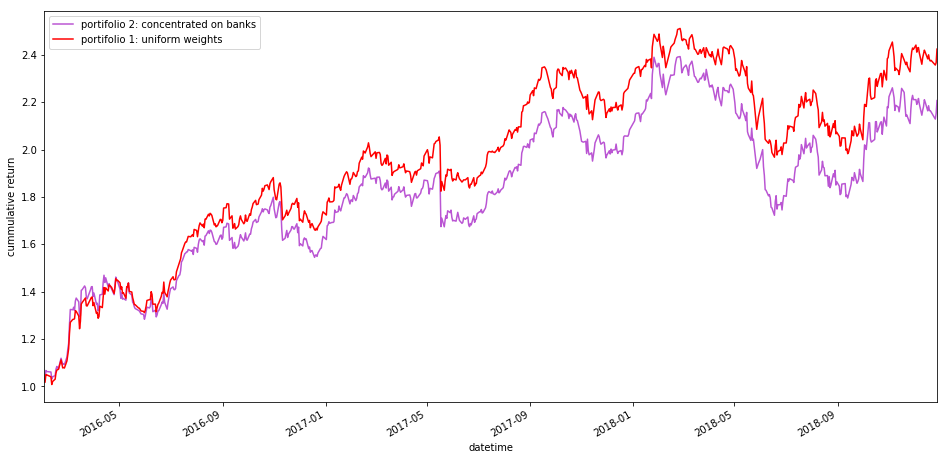

In [14]:
uniform_cum_returns = (1 + uniform_returns).cumprod()
uniform_cum_returns.name = "portifolio 1: uniform weights"

banks_cum_returns = (1 + banks_returns).cumprod()
banks_cum_returns.name = "portifolio 2: concentrated on banks"

fig, ax = plt.subplots(figsize=(16,8))
banks_cum_returns.plot(ax=ax, color="mediumorchid");
uniform_cum_returns.plot(ax=ax, color="red");

plt.legend(loc="best");
ax.set_ylabel("cummulative return");

## Using PyportfolioOpt for portfolio optimization


### Three types of optimized portfolios:

   - Maximun Sharpe portfolios
   - Minimum volatility portfolio
   - Maximun Sharpe portfolios obtained by exponentially weighted returns

In [15]:
mu = expected_returns.mean_historical_return(all_prices)
Sigma = risk_models.sample_cov(all_prices)
ef = EfficientFrontier(mu,Sigma)
best_sharpe_p = pd.DataFrame(ef.max_sharpe(), index=[0])

print("max sharpe portfolio:")
show_clean_p(best_sharpe_p)

_ = ef.portfolio_performance(verbose=True, risk_free_rate=rfr)

print()

min_vol_p = pd.DataFrame(ef.min_volatility(), index=[0])

print("min vol portfolio:")
show_clean_p(min_vol_p)

_ = ef.portfolio_performance(verbose=True, risk_free_rate=rfr)

mu_ema = expected_returns.ema_historical_return(all_prices, span=252, frequency=252)
Sigma_ew = risk_models.exp_cov(all_prices, span=180, frequency=252)
ef_ew = EfficientFrontier(mu_ema, Sigma_ew)


max_sharpe_ew_p = pd.DataFrame(ef_ew.max_sharpe(), index=[0])

print()

print("max sharpe portfolio with exponetially weighted returns:")
show_clean_p(max_sharpe_ew_p)

_ = ef_ew.portfolio_performance(verbose=True, risk_free_rate=rfr)

max sharpe portfolio:


,BRAP4,BTOW3,CVCB3,ELET3,EQTL3,GOLL4,MGLU3,VVAR3
0,31.0%,1.0%,24.3%,3.1%,9.4%,8.7%,18.7%,3.7%


Expected annual return: 90.8%
Annual volatility: 33.4%
Sharpe Ratio: 2.59

min vol portfolio:


,BRAP4,CVCB3,ELET3,GOLL4,MGLU3,VVAR3
0,35.4%,21.7%,3.3%,12.6%,23.7%,3.3%


Expected annual return: 102.0%
Annual volatility: 37.8%
Sharpe Ratio: 2.59

max sharpe portfolio with exponetially weighted returns:


,BTOW3,CMIG4,GOLL4,HGTX3,MGLU3,SULA11
0,8.4%,21.5%,2.6%,23.7%,12.8%,31.0%


Expected annual return: 81.8%
Annual volatility: 28.3%
Sharpe Ratio: 2.74


### Backtesting (2016-2018)

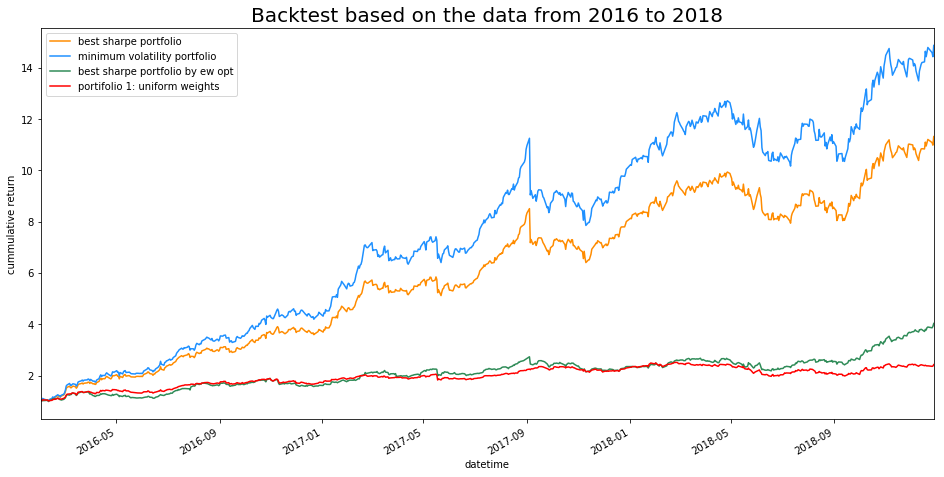

In [16]:
best_sharpe_weights = best_sharpe_p.values.flatten()
best_sharpe_returns = returns.dot(best_sharpe_weights)
best_sharpe_cum_returns = (1 + best_sharpe_returns).cumprod()
best_sharpe_cum_returns.name = "best sharpe portfolio"


best_sharpe_ew_weights = max_sharpe_ew_p.values.flatten()
best_sharpe_ew_returns = returns.dot(best_sharpe_ew_weights)
best_sharpe_ew_cum_returns = (1 + best_sharpe_ew_returns).cumprod()
best_sharpe_ew_cum_returns.name = "best sharpe portfolio by ew opt"




min_vol_weights = min_vol_p.values.flatten()
min_vol_returns = returns.dot(min_vol_weights)
min_vol_cum_returns = (1 + min_vol_returns).cumprod()
min_vol_cum_returns.name = "minimum volatility portfolio"


fig, ax = plt.subplots(figsize=(16,8))
best_sharpe_cum_returns.plot(ax=ax, color="darkorange");
min_vol_cum_returns.plot(ax=ax, color="dodgerblue")
best_sharpe_ew_cum_returns.plot(ax=ax, color="seagreen")
uniform_cum_returns.plot(ax=ax, color="red");
plt.legend(loc="best");
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2016 to 2018", fontsize=20);

### Eval (2019-2020)

Best portfolio:  best sharpe portfolio by ew opt
Final cumulative return: 0.96 


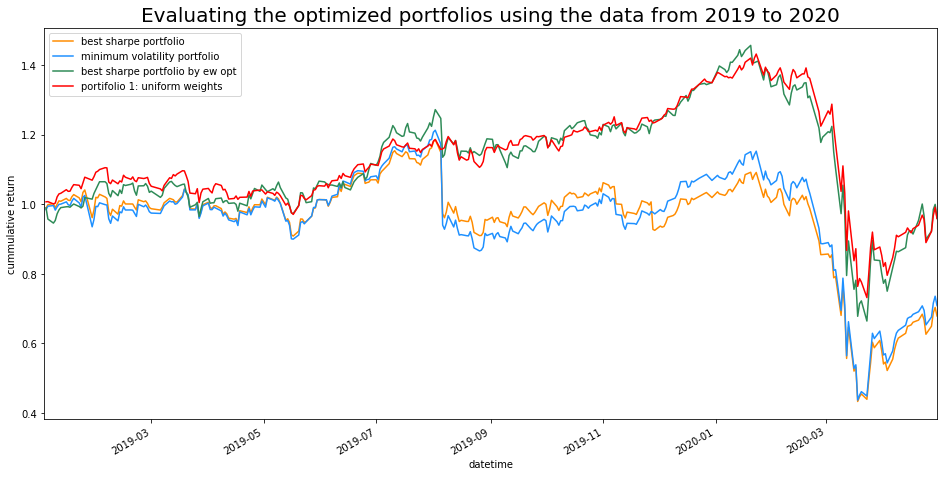

In [17]:
all_prices_test = []

for ticker in ibov_mini:
    series = df_test.xs(ticker).close
    series.name = ticker
    all_prices_test.append(series)
    
returns_test = pd.DataFrame(all_prices_test).transpose().pct_change()

est_sharpe_weights = best_sharpe_p.values.flatten()
best_sharpe_returns = returns_test.dot(best_sharpe_weights)
best_sharpe_cum_returns = (1 + best_sharpe_returns).cumprod()
best_sharpe_cum_returns.name = "best sharpe portfolio"

best_sharpe_ew_weights = max_sharpe_ew_p.values.flatten()
best_sharpe_ew_returns = returns_test.dot(best_sharpe_ew_weights)
best_sharpe_ew_cum_returns = (1 + best_sharpe_ew_returns).cumprod()
best_sharpe_ew_cum_returns.name = "best sharpe portfolio by ew opt"

min_vol_weights = min_vol_p.values.flatten()
min_vol_returns = returns_test.dot(min_vol_weights)
min_vol_cum_returns = (1 + min_vol_returns).cumprod()
min_vol_cum_returns.name = "minimum volatility portfolio"


uniform_returns = returns_test.dot(uniform_weigths)
uniform_cum_returns = (1 + uniform_returns).cumprod()
uniform_cum_returns.name = "portifolio 1: uniform weights"


fig, ax = plt.subplots(figsize=(16,8))
best_sharpe_cum_returns.plot(ax=ax, color="darkorange");
min_vol_cum_returns.plot(ax=ax, color="dodgerblue")
best_sharpe_ew_cum_returns.plot(ax=ax, color="seagreen")
uniform_cum_returns.plot(ax=ax, color="red");
plt.legend(loc="best");
ax.set_ylabel("cummulative return");
ax.set_title("Evaluating the optimized portfolios using the data from 2019 to 2020", fontsize=20);

ps_cum = [best_sharpe_cum_returns, min_vol_cum_returns, best_sharpe_ew_cum_returns]
ps = [best_sharpe_returns, min_vol_returns, best_sharpe_ew_returns]

final_return = []
for p in ps_cum:
    final_return.append(p.iloc[-1])
    
id_ = np.argmax(final_return)
best_p = ps[id_]
best_p.name = (ps_cum[id_]).name 

print("Best portfolio: ",  best_p.name)
print("Final cumulative return: {:.2f} ".format(final_return[id_]))

## Using Pyfolio to analyse the best portfolio for 2019-2020

Start date,2019-01-03
End date,2020-04-30
Total months,15
,Backtest
Annual return,-3.0%
Cumulative returns,-4.0%
Annual volatility,46.2%
Sharpe ratio,0.17
Calmar ratio,-0.06
Stability,0.03
Max drawdown,-54.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,54.41,2020-01-20,2020-03-23,NaT,NaN
1,13.11,2019-08-02,2019-09-10,2019-12-11,94
2,9.44,2019-03-12,2019-03-27,2019-05-31,59
3,4.44,2019-01-03,2019-01-07,2019-01-11,7
4,4.22,2019-02-04,2019-03-06,2019-03-12,27


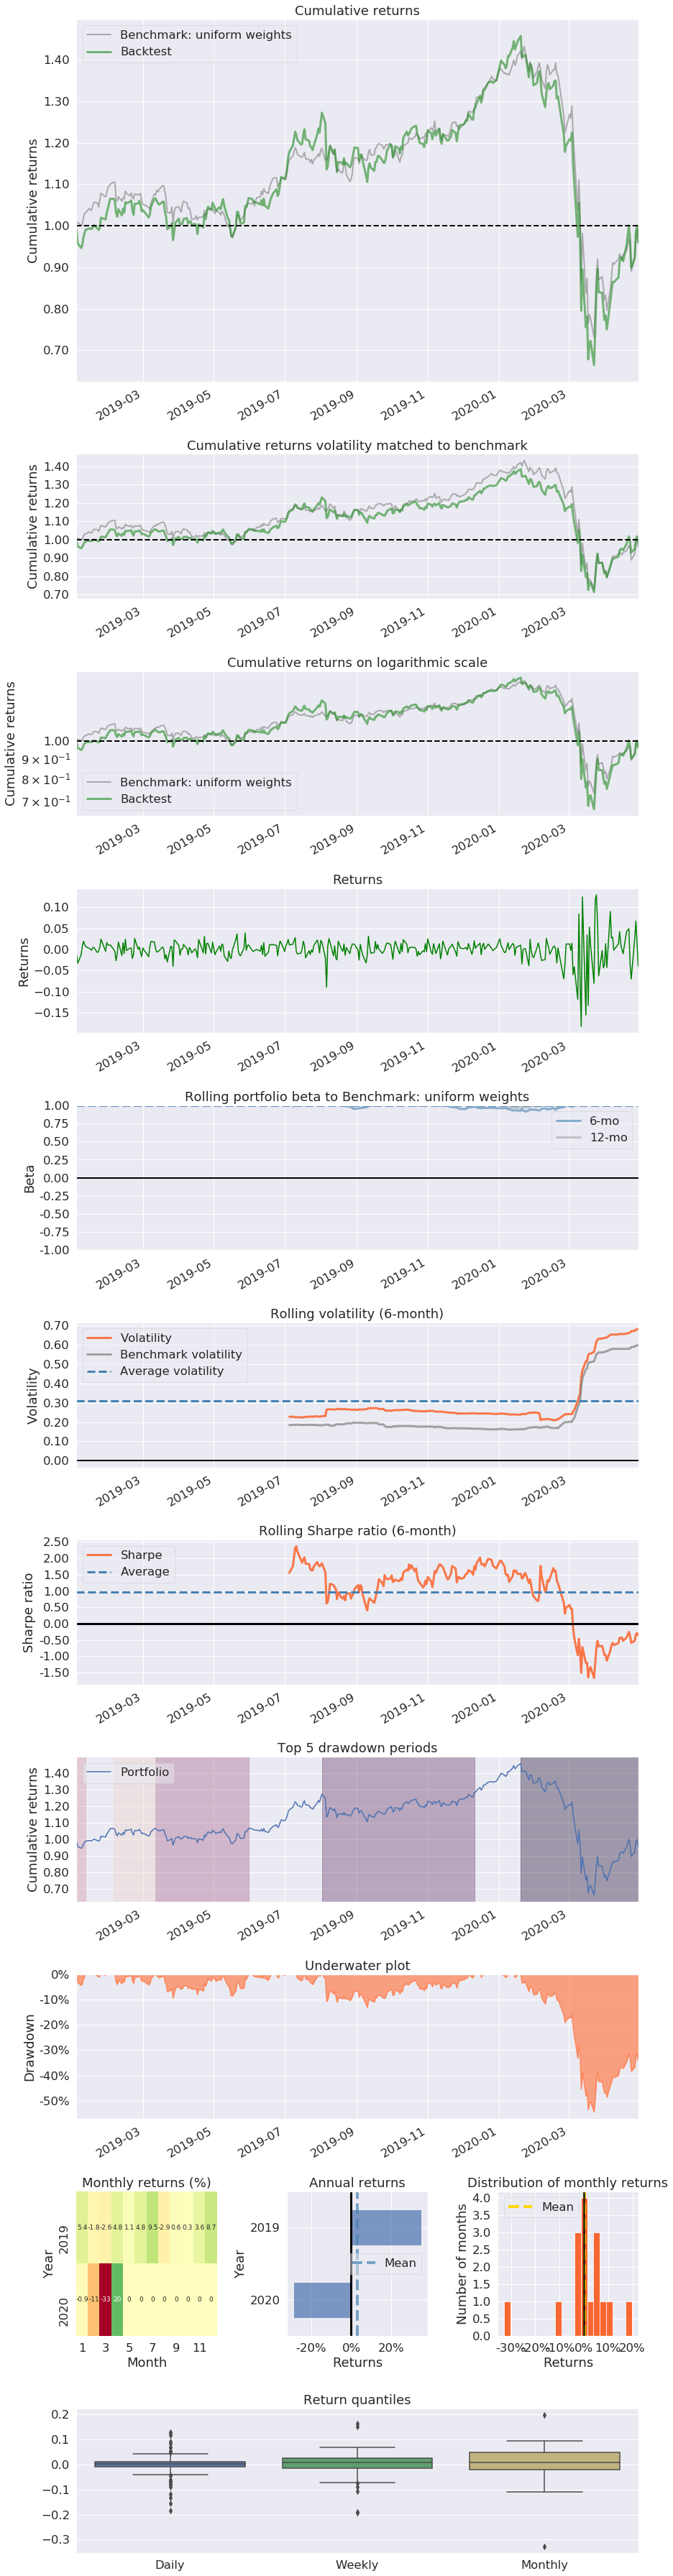

In [18]:
uniform_returns.name = "Benchmark: uniform weights"
pf.create_returns_tear_sheet(best_p.dropna(), benchmark_rets=uniform_returns.dropna())
